# Summary: Visualize how words in lyrics affect Age-Ratings.

#  Load Lyrics and Preprocess

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import os
%matplotlib inline

In [2]:
df = pd.read_csv('../data/all.csv')
df = df.dropna(subset=['lyrics'])
df = df.reset_index(drop=True)

import re

def remove_disclaimer(string):
    s = re.sub(r'(\*)+ This Lyrics is NOT for Commercial use .*\r\n\([0-9]*\)',"", string)
    return s

df['lyrics'] = df['lyrics'].apply(remove_disclaimer)

In [3]:
import spacy
import re

nlp = spacy.load("en_core_web_sm",  disable=['parser','ner', 'textcat'])


def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w\w\w+\b', doc)) 
    return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      if len(w.lemma_)>2 ]

def process_text(text, stop_words=set()):
    if not text:
        return []

    text = ' '.join(re.findall(r'\b\w\w\w+\b', text))   #only keep word with at least 3 chars
    doc = nlp(text)
    result=  [token.lemma_.lower() for token in doc if token.lemma_.lower() not in stop_words]
    result = " ".join(result)
    return result



stopwords = spacy.lang.en.STOP_WORDS.union(['-pron-', 'oh','ooh','la'])
stopwords = set(my_lemmatizer(' '.join(list(stopwords))))



In [4]:
df['processed_lyrics'] = df['lyrics'].apply(process_text, args=(stopwords,))

df['processed_lyrics'].head(3)

0    old transylvania be lad castle be poor be sad ...
1    saw monster mirror wake today monster mirror d...
2    big red car roll street people meet like hello...
Name: processed_lyrics, dtype: object

## Divide data into two age groups:  Young (Age=2~8), Old (Age=12-18)

In [5]:
df_age = df[(df['Age']<9) | (df['Age']>11)].copy()
df_age['group'] = df_age['Age'].apply(lambda x: 'young' if x<9 else 'old' )
df_age = df_age[['processed_lyrics','group']]
df_age = df_age.dropna(subset=['processed_lyrics'])
df_age.sample(5)

,processed_lyrics,group
6207,sensible incredible single friend be jealous n...,old
10302,think pretty makeup think funny tell punch lin...,old
13215,beautiful beautiful know beautiful beautiful k...,young
6562,think day tell story meet spark fly instantly ...,old
2756,break hear blind cause be dance pray heart tur...,young


## Find the most polarized 50 words ( 25 young , 25 old)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidfVectorizer = TfidfVectorizer()
tfidfVectorizer.fit_transform(df_age['processed_lyrics'])

<11586x22361 sparse matrix of type '<class 'numpy.float64'>'
	with 392205 stored elements in Compressed Sparse Row format>

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
X_train = tfidfVectorizer.transform(df_age['processed_lyrics'])
clf.fit(X_train, df_age['group'])

MultinomialNB()

In [8]:
clf.classes_

array(['old', 'young'], dtype='<U5')

In [47]:
from pprint import pprint
matrix = clf.feature_log_prob_ 
_, ncols = matrix.shape
polarity = [(i,0) for i in range(ncols)]
for j in range(ncols):
    polarity[j] = (j, matrix[0][j] - matrix[1][j])       #(index, log(p(w|old)) - log(p(w|young))

polarity.sort(key=lambda x: x[1])


In [48]:
polarity = polarity[0:25] + polarity[-50::]
word_prob =[(matrix[1][pol[0]], matrix[0][pol[0]]) for pol in polarity]

polar_words = [tfidfVectorizer.get_feature_names_out()[x[0]] for x in polarity]
print (polar_words[0:25])
print (polar_words[70:25:-1])

['mistletoe', 'christmas', 'santa', 'wiggles', 'twinkle', 'carly', 'roast', 'pirate', 'sleigh', 'reindeer', 'claus', 'quack', 'kryptonite', 'carol', 'murray', 'freddie', 'turkey', 'choo', 'aglow', 'yuletide', 'magical', 'muppet', 'henry', 'wubba', 'gary']
['niggas', 'sexy', 'ass', 'sex', 'fuckin', 'motherfucker', 'hoe', 'damn', 'wit', 'dick', 'homie', 'hell', 'pussy', 'club', 'lil', 'niggaz', 'hood', 'gun', 'fucking', 'drug', 'verse', 'gangsta', 'pill', 'body', 'dem', 'smoke', 'ayy', 'death', 'chick', 'kill', 'gon', 'rap', 'drink', 'shady', 'bullet', 'thang', 'weed', 'wrist', 'womanizer', 'bar', 'pimp', 'ridin', 'murder', 'dope', 'dat']


## Unsurprisingly, the "old"-end of the most polarized words are almost all explicit words. I ignore them to get other more interesting polarized words.

In [49]:
polarity = polarity[0:25] + polarity[25:50]
polar_words = [tfidfVectorizer.get_feature_names_out()[x[0]] for x in polarity]
word_prob =[(matrix[1][pol[0]], matrix[0][pol[0]]) for pol in polarity]

print (polar_words[0:25])
print (polar_words[25:])

['mistletoe', 'christmas', 'santa', 'wiggles', 'twinkle', 'carly', 'roast', 'pirate', 'sleigh', 'reindeer', 'claus', 'quack', 'kryptonite', 'carol', 'murray', 'freddie', 'turkey', 'choo', 'aglow', 'yuletide', 'magical', 'muppet', 'henry', 'wubba', 'gary']
['clique', 'dat', 'dope', 'murder', 'ridin', 'pimp', 'bar', 'womanizer', 'wrist', 'weed', 'thang', 'bullet', 'shady', 'drink', 'rap', 'gon', 'kill', 'chick', 'death', 'ayy', 'smoke', 'dem', 'body', 'pill', 'gangsta']


## Plot the word using conditional log-probabilities as the (x,y) coordinates.

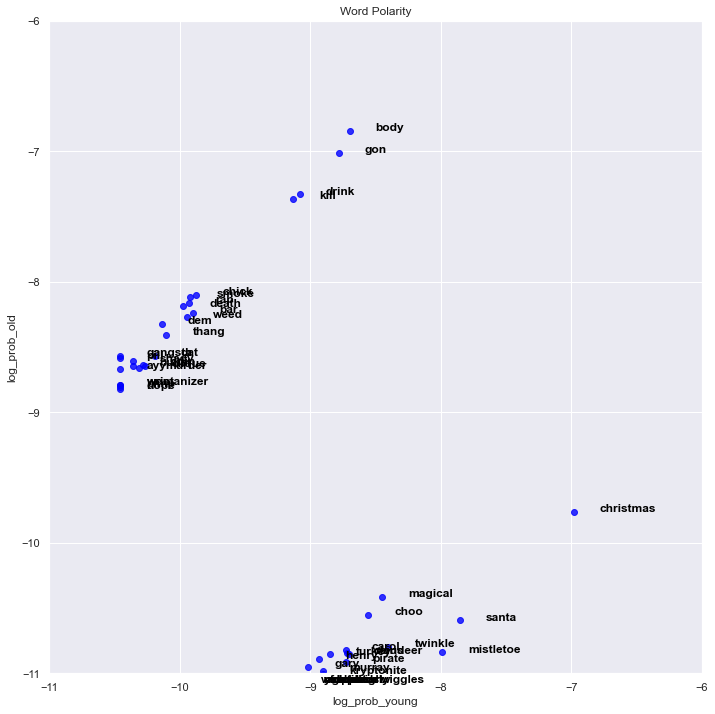

['mistletoe', 'christmas', 'santa', 'wiggles', 'twinkle', 'carly', 'roast', 'pirate', 'sleigh', 'reindeer', 'claus', 'quack', 'kryptonite', 'carol', 'murray', 'freddie', 'turkey', 'choo', 'aglow', 'yuletide', 'magical', 'muppet', 'henry', 'wubba', 'gary']
['clique', 'dat', 'dope', 'murder', 'ridin', 'pimp', 'bar', 'womanizer', 'wrist', 'weed', 'thang', 'bullet', 'shady', 'drink', 'rap', 'gon', 'kill', 'chick', 'death', 'ayy', 'smoke', 'dem', 'body', 'pill', 'gangsta']


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
import math
 
# Create dataframe
df = pd.DataFrame({
'log_prob_young': [ p[0] for p in word_prob],
'log_prob_old': [p[1] for p in word_prob],
'word': polar_words
})

plt.rcParams["figure.figsize"] = (12,12)

sns.regplot(data=df, x="log_prob_young", y="log_prob_old", fit_reg=False, marker="o", color="blue").set_aspect(aspect='equal')

for line in range(0,df.shape[0]):
     plt.text(df.log_prob_young[line]+0.2, df.log_prob_old[line], df.word[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.ylim([-11, -6])
plt.xlim([-11, -6])
plt.title("Word Polarity")    

plt.savefig('../figures/word_polarity.png')
plt.show()

print (polar_words[0:25])
print (polar_words[25:50])